In [1]:
import torch
from torch.autograd import Variable

from PIL import Image
import numpy as np

from functools import partial
import sys
import matplotlib.pyplot as plt
import cv2


import torch.nn as nn
import torchvision.models as models

from collections import OrderedDict

import pdb

In [2]:
class VGG16_Conv(nn.Module):

    def __init__(self, n_classes = 1000):   # ImageNet class categories
        super(VGG16_Conv, self).__init__()

        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            # conv2
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            # conv3
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            # conv4
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            # conv5
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # 224x244 image pooled down to 7x7 from features
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, n_classes)
        )

        self.feat_maps = OrderedDict()  # store all (conv) feature maps

        self.pool_locs = OrderedDict() # store all max locations for pooling layers

        # index of convolutional layers
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

        self.init_weights() # initialize weights

    # initialize weights using pre-trained vgg16 on ImageNet
    def init_weights(self):
        vgg16_pretrained = models.vgg16(pretrained = True)
        for idx, layer in enumerate(vgg16_pretrained.features): # feature component
            if isinstance(layer, nn.Conv2d):
                self.features[idx].weight.data = layer.weight.data
                self.features[idx].bias.data = layer.bias.data

        for idx, layer in enumerate(vgg16_pretrained.classifier):   # classifier component
            if isinstance(layer, nn.Linear):
                self.classifier[idx].weight.data = layer.weight.data
                self.classifier[idx].bias.data = layer.bias.data

    def forward(self, x):
        for idx, layer in enumerate(self.features): # pass self.features
            if isinstance(layer, nn.MaxPool2d):
                x, locs = layer(x)
            else:
                x = layer(x)

        x = x.view(x.size()[0], -1) # reshape to (1, 512 * 7 * 7)

        output = self.classifier(x) # pass self.classifier

        return output

In [3]:
import torch.nn as nn
import torchvision.models as models

import sys

class VGG16_Deconv(nn.Module):

    def __init__(self):
        super(VGG16_Deconv, self).__init__()

        self.features = nn.Sequential(
            # deconv1
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            # deconv2
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, padding = 1),
            # deconv3
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, padding = 1),
            # deconv4
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, padding = 1),
            # deconv5
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, padding = 1)
        )

        # forward idx : backward idx
        self.conv2deconv_indices = {0:30, 2:28, 5:25, 7:23, 10:20, 12:18, 14:16, 17:13, 19:11, 21:9, 24:6, 26:4, 28:2}
        # forward idx : backward idx; not align
        self.conv2deconv_bias_indices = {0:28, 2:25, 5:23, 7:20, 10:18, 12:16, 14:13, 17:11, 19:9, 21:6, 24:4, 26:2}
        # forwardidx : backward idx
        self.relu2relu_indices = {1:29, 3:27, 6:24, 8:22, 11:19, 13:17, 15:15, 18:12, 20:10, 22:8, 25:5, 27:3, 29:1}
        # backward idx : forward idx
        self.unpool2pool_indices = {26:4, 21:9, 14:16, 7:23, 0:30}

        self.init_weights()  # initialize weights

    # initialize weights using pre-trained vgg16 on ImageNet
    def init_weights(self):
        vgg16_pretrained = models.vgg16(pretrained = True)
        for idx, layer in enumerate(vgg16_pretrained.features): # feature component
            if isinstance(layer, nn.Conv2d):
                self.features[self.conv2deconv_indices[idx]].weight.data = layer.weight.data
                if idx in self.conv2deconv_bias_indices:    # bias in first backward layer is randomly set
                    self.features[self.conv2deconv_bias_indices[idx]].bias.data = layer.bias.data

    def forward(self, x, layer, activation_idx, pool_locs):
        if layer in self.conv2deconv_indices:
            start_idx = self.conv2deconv_indices[layer]
        elif layer in self.relu2relu_indices:
            start_idx = self.relu2relu_indices[layer]
        else:
            print('No such Conv2d or RelU layer!')
            sys.exit(0)

        for idx in range(start_idx, len(self.features)):
            if isinstance(self.features[idx], nn.MaxUnpool2d):
                x = self.features[idx](x, pool_locs[self.unpool2pool_indices[idx]])
            else:
                x = self.features[idx](x)

        return x

In [4]:
def tn_deconv_img(deconv_output):
    img = deconv_output.data.numpy()[0].transpose(1, 2, 0)  # (H, W, C)
    # normalize
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.astype(np.uint8)

    return img

In [5]:
def load_image(filename ):
    img = Image.open(filename)

    return img

def preprocess(img):
    img = np.asarray(img.resize((224, 224))) # resize to 224 * 224 (W * H), np.asarray returns (H, W, C)
    img = img.transpose(2, 0, 1)    # reshape to (C, H, W)
    img = img[np.newaxis, :, :, :]  # add one dim to (1, C, H, W)

    return Variable(torch.FloatTensor(img.astype(float)))

# store all feature maps and max pooling locations during forward pass
def store_feat_maps(model):

    def hook(module, input, output, key):
       if isinstance(module, nn.MaxPool2d):
           model.feat_maps[key] = output[0]
           model.pool_locs[key] = output[1]
       else:
           model.feat_maps[key] = output

    for idx, layer in enumerate(model._modules.get('features')):    # _modules returns an OrderedDict
        layer.register_forward_hook(partial(hook, key = idx))

In [6]:

mypath = './ILSVRC2012_img_val'
from os import listdir
from os.path import isfile, join
images = [f for f in listdir(mypath) if isfile(join(mypath, f))]


number = input('Which Picture ?(0-30, -1 to exit): ')
number = int(number)

        
img_file=images[number]
    # load an image
img = load_image(mypath+'/'+img_file)
real_img = load_image(mypath+'/'+img_file)
    # preprocess an image, return a pytorch Variable
input_img = preprocess(img)

vgg16_conv = VGG16_Conv(1000)   # ImageNet class categories, build vgg16 forward network
vgg16_conv.eval()   # evaluation mode

store_feat_maps(vgg16_conv) # store all feature maps and max pooling locations during forward pass

conv_output = vgg16_conv(input_img)

vgg16_deconv = VGG16_Deconv()   # build vgg16 backward network
vgg16_deconv.eval()




Which Picture ?(0-30, -1 to exit):  -1


VGG16_Deconv(
  (features): Sequential(
    (0): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (8): ReLU()
    (9): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (15): ReLU()
    (16): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): ConvTranspose2d(256, 25

In [ ]:
layer = input('Which layer ?(0-30): ')
layer = int(layer)
new_feat_map = vgg16_conv.feat_maps[layer].clone()

In [20]:
deconv_output = vgg16_deconv(new_feat_map,layer, 6, vgg16_conv.pool_locs) #x, layer, activation_idx, pool_locs

In [21]:
new_feat_map.shape

torch.Size([1, 64, 224, 224])

In [22]:
img = tn_deconv_img(deconv_output)

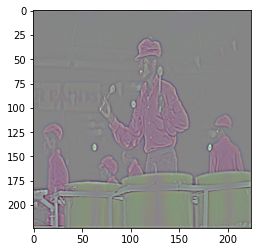

In [23]:

plt.imshow(img)


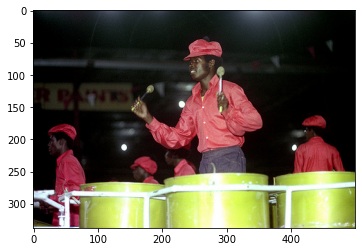

In [24]:
plt.imshow(real_img)